# Project: House Property Sales Time Series

In [2]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Number of GPUs
print(torch.cuda.get_device_name(0))  # GPU model

True
1
NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import os

# Asssessment
from pandas.plotting import scatter_matrix

# Models
from statsmodels.tsa.arima.model import ARIMA  
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


2025-03-30 16:03:41.855648: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 16:03:41.863794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743332621.874545   17002 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743332621.877552   17002 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-30 16:03:41.888714: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Data Downloading

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("htagholdings/property-sales")

print("Path to dataset files:", path)

Path to dataset files: /home/asus-creator/.cache/kagglehub/datasets/htagholdings/property-sales/versions/3


In [5]:
os.listdir("/home/asus-creator/.cache/kagglehub/datasets/htagholdings/property-sales/versions/3")

['raw_sales.csv', 'ma_lga_12345.csv']

In [6]:
df_ma = pd.read_csv(path + "/ma_lga_12345.csv")
df_raw = pd.read_csv(path + "/raw_sales.csv")

## Data Assessement

In [7]:
df_ma.head(20)

,saledate,MA,type,bedrooms
0,30/09/2007,441854,house,2
1,31/12/2007,441854,house,2
2,31/03/2008,441854,house,2
3,30/06/2008,441854,house,2
4,30/09/2008,451583,house,2
5,31/12/2008,440256,house,2
6,31/03/2009,442566,house,2
7,30/06/2009,446113,house,2
8,30/09/2009,440123,house,2
9,31/12/2009,442131,house,2


In [8]:
df_raw.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


In [9]:
df_ma.describe()

,MA,bedrooms
count,3.470000e+02,347.000000
mean,5.481320e+05,2.867435
std,1.701934e+05,1.239875
min,3.167510e+05,1.000000
25%,4.277395e+05,2.000000
50%,5.077440e+05,3.000000
75%,6.275155e+05,4.000000
max,1.017752e+06,5.000000


In [10]:
df_raw.describe()

,postcode,price,bedrooms
count,29580.000000,2.958000e+04,29580.000000
mean,2730.249730,6.097363e+05,3.250169
std,146.717292,2.817079e+05,0.951275
min,2600.000000,5.650000e+04,0.000000
25%,2607.000000,4.400000e+05,3.000000
50%,2615.000000,5.500000e+05,3.000000
75%,2905.000000,7.050000e+05,4.000000
max,2914.000000,8.000000e+06,5.000000


In [11]:
df_ma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   saledate  347 non-null    object
 1   MA        347 non-null    int64 
 2   type      347 non-null    object
 3   bedrooms  347 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.0+ KB


In [12]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   datesold      29580 non-null  object
 1   postcode      29580 non-null  int64 
 2   price         29580 non-null  int64 
 3   propertyType  29580 non-null  object
 4   bedrooms      29580 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [13]:
df_ma.isnull().sum()

saledate    0
MA          0
type        0
bedrooms    0
dtype: int64

In [14]:
df_raw.isnull().sum()

datesold        0
postcode        0
price           0
propertyType    0
bedrooms        0
dtype: int64

In [15]:
print(df_ma.columns)
print(df_raw.columns)


Index(['saledate', 'MA', 'type', 'bedrooms'], dtype='object')
Index(['datesold', 'postcode', 'price', 'propertyType', 'bedrooms'], dtype='object')


### Data Vizualization

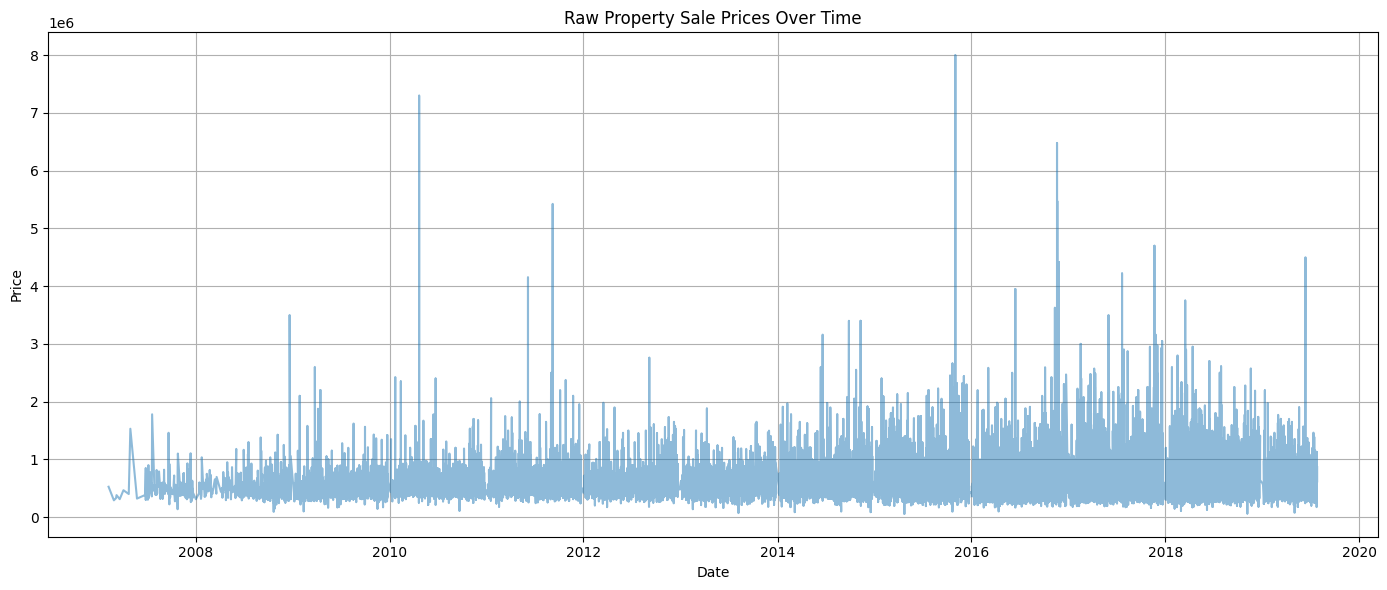

In [16]:
# Plot raw prices
df_raw.columns = df_raw.columns.str.strip()
df_raw['datesold'] = pd.to_datetime(df_raw['datesold'])
df_raw = df_raw.sort_values(by='datesold')

plt.figure(figsize=(14, 6))
plt.plot(df_raw['datesold'], df_raw['price'], label='Raw Sale Prices', alpha=0.5)
plt.title('Raw Property Sale Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_17002/1641994868.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_ma['saledate'] = pd.to_datetime(df_ma['saledate'])


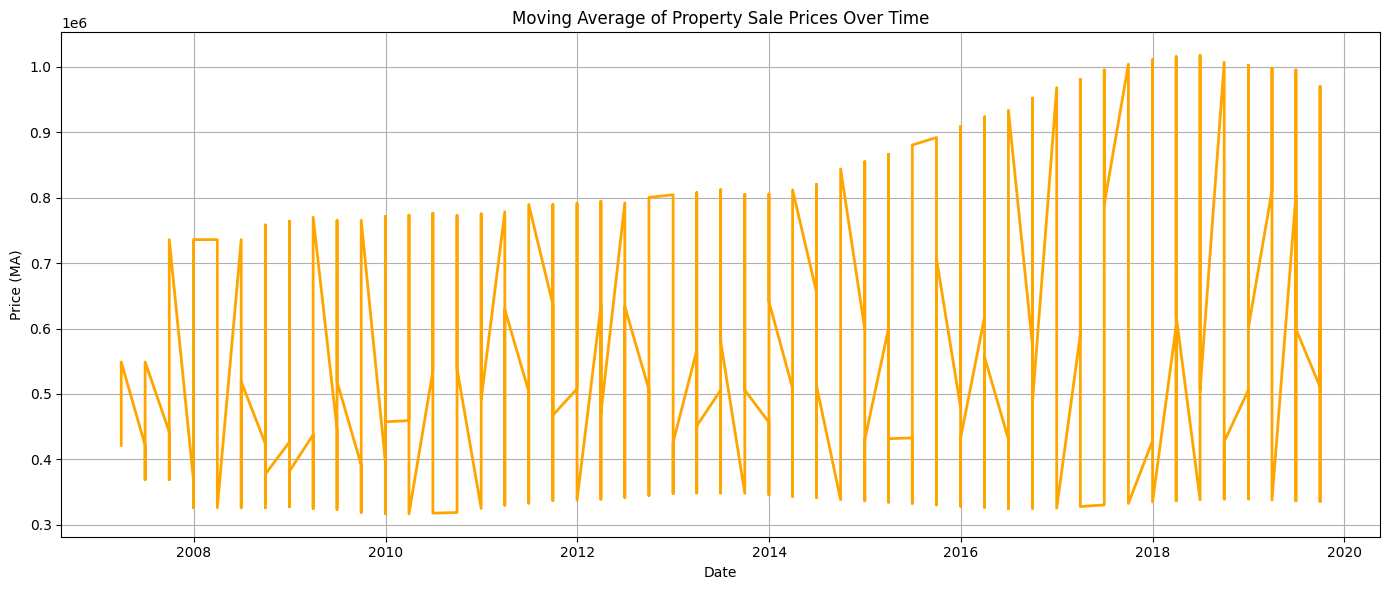

In [17]:
df_ma.columns = df_ma.columns.str.strip()
df_ma['saledate'] = pd.to_datetime(df_ma['saledate'])
df_ma = df_ma.sort_values(by='saledate')

plt.figure(figsize=(14, 6))
plt.plot(df_ma['saledate'], df_ma['MA'], label='Moving Average Price', color='orange', linewidth=2)
plt.title('Moving Average of Property Sale Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (MA)')
plt.grid(True)
plt.tight_layout()
plt.show()


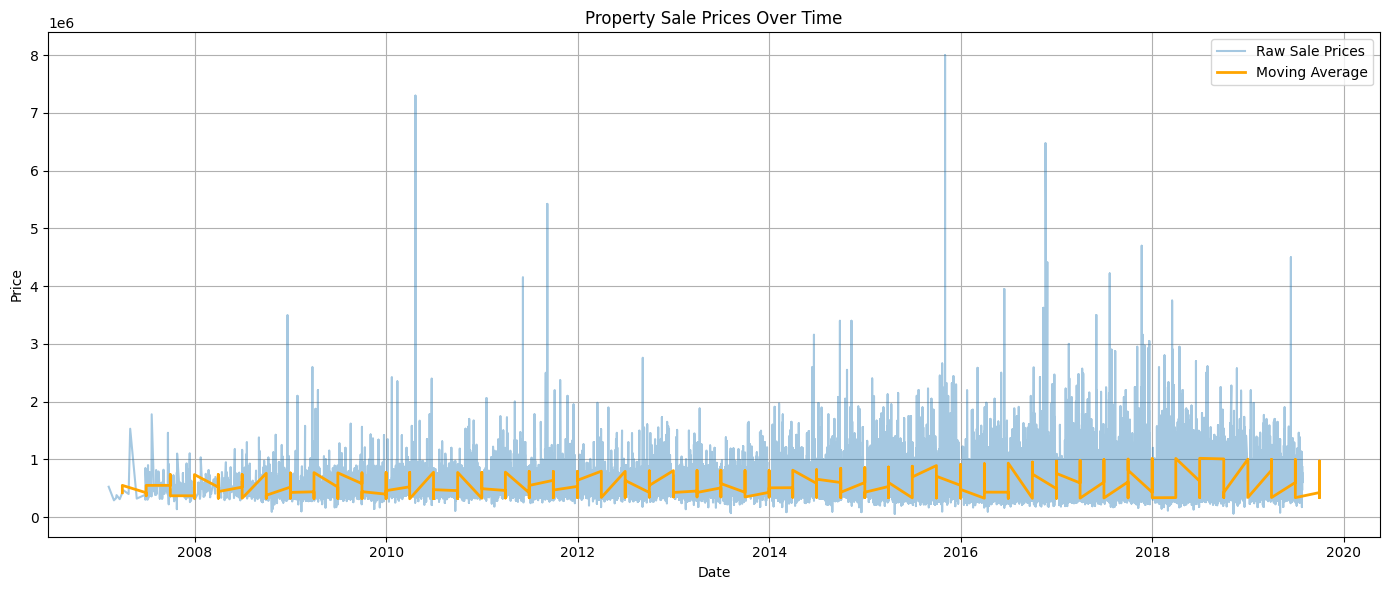

In [18]:
df_ma['saledate'] = pd.to_datetime(df_ma['saledate'])
df_raw['datesold'] = pd.to_datetime(df_raw['datesold'])

df_ma = df_ma.sort_values(by='saledate')
df_raw = df_raw.sort_values(by='datesold')

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(df_raw['datesold'], df_raw['price'], label='Raw Sale Prices', alpha=0.4)
plt.plot(df_ma['saledate'], df_ma['MA'], label='Moving Average', linewidth=2, color='orange')

plt.title('Property Sale Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Data Preprocessing

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Clean and prepare
df_ma.columns = df_ma.columns.str.strip()
df_ma['saledate'] = pd.to_datetime(df_ma['saledate'])
df_ma = df_ma.sort_values('saledate')

# Set index
ts = df_ma.set_index('saledate')['MA']


In [20]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -1.9037662162459756
p-value: 0.3302914433184093


In [21]:
ts_diff = ts.diff().dropna()

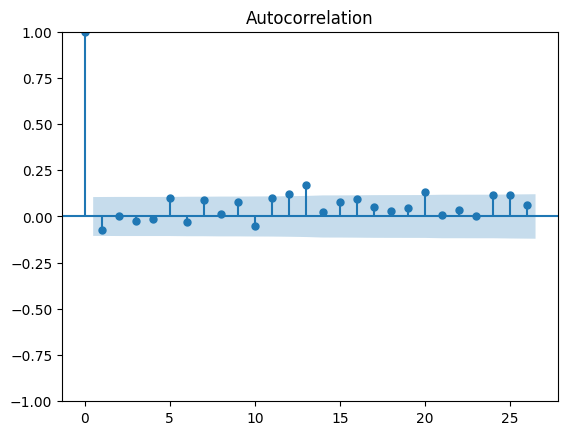

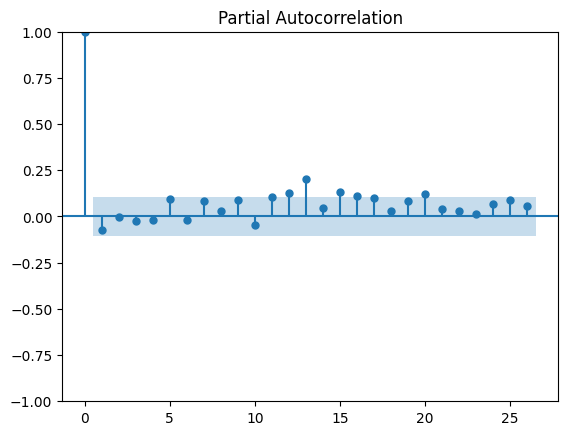

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts)
plot_pacf(ts)
plt.show()


In [23]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA(p, d, q) — d=0 for ARMA
model = ARIMA(ts, order=(2, 0, 1))  # Example: ARMA(2,1)
result = model.fit()
print(result.summary())


                               SARIMAX Results                                
Dep. Variable:                     MA   No. Observations:                  347
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -4670.436
Date:                Sun, 30 Mar 2025   AIC                           9350.873
Time:                        16:03:44   BIC                           9370.119
Sample:                             0   HQIC                          9358.536
                                - 347                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.481e+05   8502.274     64.469      0.000    5.31e+05    5.65e+05
ar.L1          0.2475      4.422      0.056      0.955      -8.419       8.914
ar.L2          0.0134      0.342      0.039      0.9

/home/asus-creator/MLC/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/asus-creator/MLC/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/asus-creator/MLC/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/asus-creator/MLC/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting param

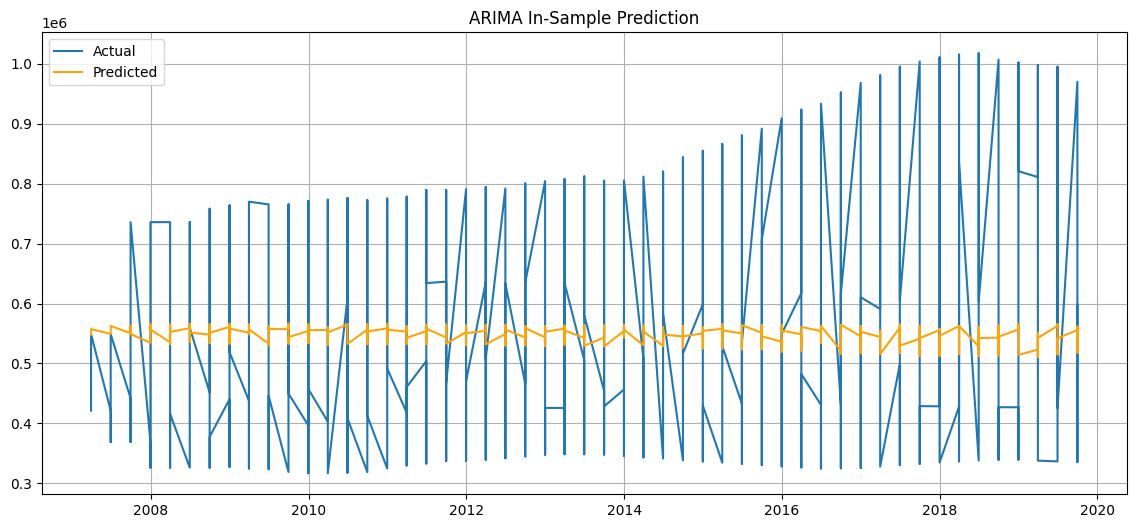

In [24]:
# Predict in-sample
pred = result.predict(start=0, end=len(ts)-1)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(ts, label='Actual')
plt.plot(pred, label='Predicted', color='orange')
plt.legend()
plt.title('ARIMA In-Sample Prediction')
plt.grid(True)
plt.show()


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mae = mean_absolute_error(ts, pred)
mse = mean_squared_error(ts, pred)
rmse = np.sqrt(mse)
r2 = r2_score(ts, pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


MAE: 134378.02
MSE: 28725416852.96
RMSE: 169485.74
R² Score: 0.01
